In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

import sys
import logging
import matplotlib.pyplot as plt
import numpy as np
import re 

import logging
logging.basicConfig(level=logging.ERROR,format='%(asctime)s %(filename)s[line:%(lineno)d] %(funcName)s %(message)s',datefmt='%a, %d %b %Y %H:%M:%S')

In [2]:
# load original keyname_weight file

def load_data(filename,newStyle=True):
    logging.debug("filename:%s"%filename)
    mapFea2ValAndWeightList = {}
    
    for line in open(filename):
        if -1 == line.find('*') or -1 == line.find('='):
            continue
            
        k=""
        v=""
        w=""
        if newStyle :
            k,v,count,w = re.split("[*|\t|=]",line)
        else:
            kv, w = line.split('=')
            k, v = kv.split('*')
        
        w = float(w)
        # value is a list
        if k not in mapFea2ValAndWeightList.keys():
            mapFea2ValAndWeightList[k] = [[v, w]]
        else:
            mapFea2ValAndWeightList[k].append([v, w])
    return mapFea2ValAndWeightList

def getMapFea2Weight(mapFea2ValAndWeightList,  top=5):
    mapFea2Weight = {}
    mapFea2ValueCount = {}

    #计算每个特征的 有效权重

    for (fea,valAndWeightList ) in mapFea2ValAndWeightList.items():
        weightList=[]
        for val,weight in valAndWeightList:
            weightList.append(weight)
        std = np.std(weightList,ddof=1)
        mapFea2Weight[fea] = 0 if np.isnan(std) else std#用均方差来衡量特征的区分能力
       

    mapFea2Weight_Sorted = sorted(mapFea2Weight.items(), key=lambda d: d[1], reverse=True)
    return mapFea2Weight_Sorted[0:top]


In [3]:
#/opt/esearch/1/lijiangtao/process/qualityRank/sample/sample/sample_ljtesf_app.json
#加载 特征名称，以便画出的图中不再是标号 ，而是特征名称，方便查看
import json
filename="/home/hdp_teu_search/ljt/process/xcf_sample/join_sample/scripts/jsons/sample_ljtesf2_app.json"
def getSamprefix2Name(filename,mapSamplePrefix2Name): 
    fp = open(filename,"r")
    listSampleIndex2List = json.load(fp)

    for sampleIndex,itemDict in listSampleIndex2List:
        if -1 == itemDict['samplePrefix'].find(":"):
            continue
        mapSamplePrefix2Name[itemDict['samplePrefix'].strip(":")] = itemDict['name']
        logging.debug("samplePrefix:%s,name(%s)" %(itemDict['samplePrefix'].strip(":"),itemDict['name']))

def mapFeature2Name(feature,mapSamplePrefix2Name):
    feaList = feature.split("+")
    return "+".join([mapSamplePrefix2Name[fea.split("~",1)[0]]  for fea in feaList])

mapSamplePrefix2Name={}
getSamprefix2Name(filename,mapSamplePrefix2Name)


In [4]:
def drawHist(names,values, title, the_color='b', fignum=1, subnum=111, xlabel='x', ylabel='y'):
    plt.figure(fignum, figsize=(10, 20))
    plt.subplot(subnum)
    y_pos = np.arange(len(names))

    plt.barh(y_pos, values, height=0.5,align='center', alpha=0.8, color="b")
    plt.yticks(y_pos, names)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)

In [5]:
####
#keyname_weight_filePath ="/home/hdp_teu_search/lxt/qualityRankPlace/checkSampleSvn/ykForCvr/validate_ly/validate_ly_posOri_testNosample/output_testly_addData_posOri_testNosample/lr/keyname_weight"

#keyname_weight_filePath = "/home/hdp_teu_search/ljt/process/qualityRank/result_20161101_20161120_ratio_1_10/output_timeOnPage6/lr/keyname_weight" 
keyname_weight_filePath="/home/hdp_teu_search/ljt/process/qualityRank/result_result_20161101_201611300_ratio_1_10_auc0.634/output_timeOnPage9/lr/keyname_weight"
#keyname_weight_filePath="/home/hdp_teu_search/ljt/process/qualityRank/train/sample7/script/cal_feastdev_new/test_weight"
mapFea2ValAndWeightList = load_data(keyname_weight_filePath,newStyle=True)
mapFea2Weight_Sorted = getMapFea2Weight(mapFea2ValAndWeightList, 1000)

/home/hdp_teu_search/ljt/anacoda_env/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


In [6]:
df2 = pd.DataFrame.from_dict(mapFea2Weight_Sorted)
df2.head()

,0,1
0,117,0.144819
1,367,0.070613
2,211,0.040254
3,214,0.031235
4,108,0.028478


In [7]:
df2.columns=["feature","weight"]

In [8]:
df2.head()

,feature,weight
0,117,0.144819
1,367,0.070613
2,211,0.040254
3,214,0.031235
4,108,0.028478


In [9]:
mapSamplePrefix2Name={}
getSamprefix2Name(filename,mapSamplePrefix2Name)

feaNames=[]
for feature in df2.feature:
    feaNames.append(mapFeature2Name(feature,mapSamplePrefix2Name))

df2["feaNames"] = feaNames
df2.head()

,feature,weight,feaNames
0,117,0.144819,house_position_subwayline
1,367,0.070613,hctr_all
2,211,0.040254,hla
3,214,0.031235,isbiz
4,108,0.028478,house_property_type


In [10]:
df2["cumulation"] =df2.weight.cumsum()
df2.head()

,feature,weight,feaNames,cumulation
0,117,0.144819,house_position_subwayline,0.144819
1,367,0.070613,hctr_all,0.215433
2,211,0.040254,hla,0.255687
3,214,0.031235,isbiz,0.286922
4,108,0.028478,house_property_type,0.315399


In [11]:
df2=df2.sort('weight')

/opt/esearch/1/lijiangtao/anacoda_env/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


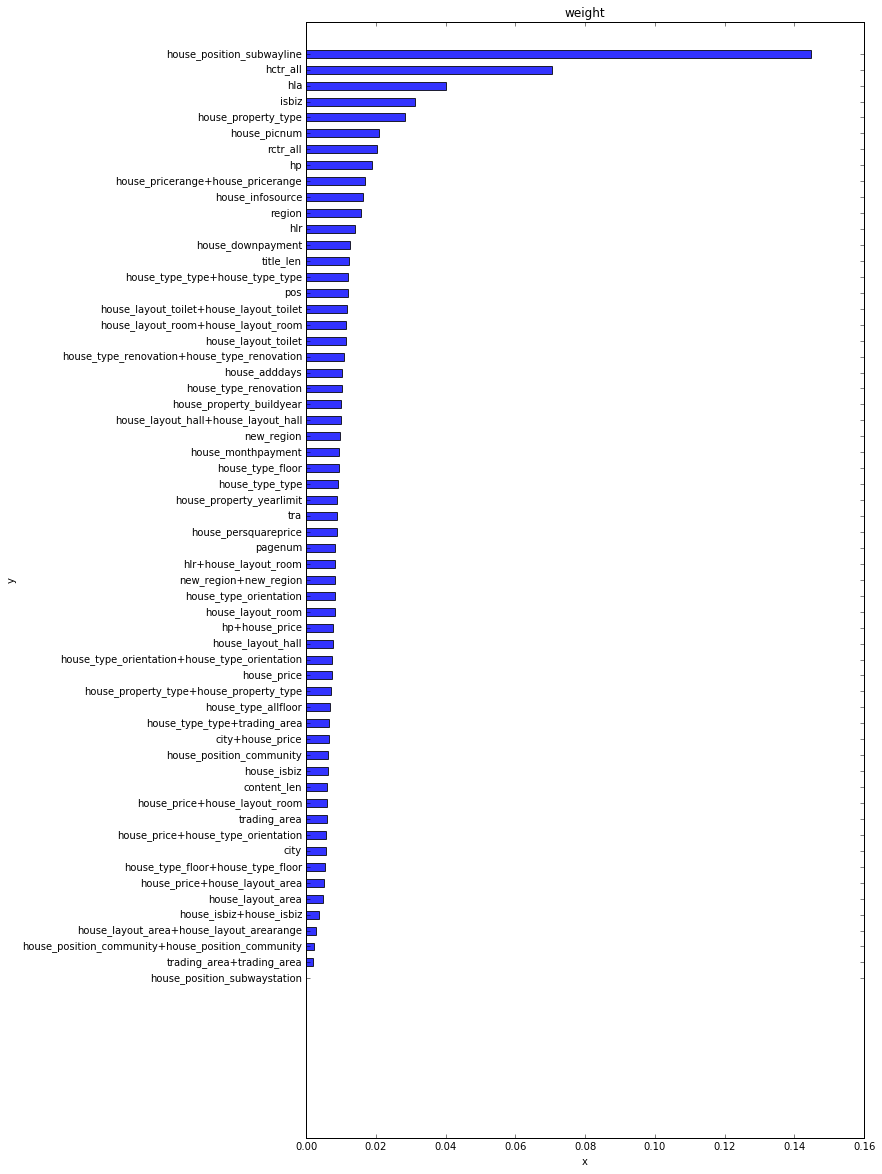

In [12]:
drawHist(df2.feaNames,df2.weight,"weight")

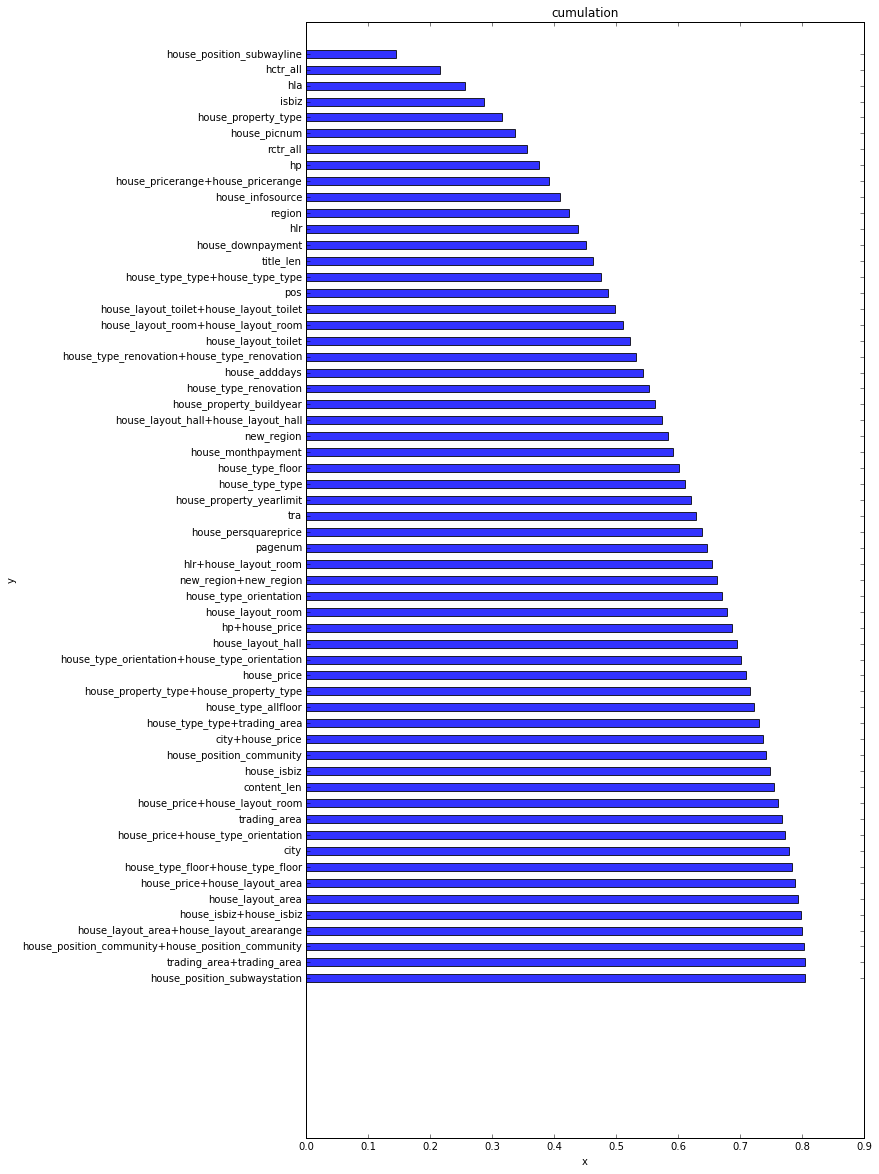

In [13]:
drawHist(df2.feaNames,df2.cumulation,"cumulation")

In [14]:
df2.tail()

,feature,weight,feaNames,cumulation
4,108,0.028478,house_property_type,0.315399
3,214,0.031235,isbiz,0.286922
2,211,0.040254,hla,0.255687
1,367,0.070613,hctr_all,0.215433
0,117,0.144819,house_position_subwayline,0.144819


In [15]:
print type(df2.feaNames[-30:])

<class 'pandas.core.series.Series'>


In [16]:
df2.to_csv("/tmp/var_df.csv")